In [2619]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from sklearn.model_selection import cross_val_score
from scipy.stats import norm, skew

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2620]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2621]:
### Reading CSV File
Data = pd.read_csv('Bio_Project_Data/features.csv')

In [2622]:
def labeling():

    Data.columns = Data.columns.str.replace(' ', '')
    Data['motif_family'] = Data['motif_family'].str.replace(' ', '')
    
    ### Assigning Class '0' to unknown motifs
    Data['motif_family'] = Data['motif_family'].replace(to_replace ='IL-*', value = 0, regex = True)
    Data['motif_family'] = Data['motif_family'].replace(to_replace ='Beak-*', value = 0, regex = True)
    
    
    family = {0 : 0, 'X-loop': 0, 'U-turn': 0, 'Extended-hand': 0, 'Kink-turn': 1, 'Sarcin-ricin': 2, 'Tandem-shear': 3, 'reverse-Kink-turn': 4, 'Hook-turn': 4, 'C-loop': 4, 'E-loop': 4, 'Tetraloop-receptor': 4, 'L1-complex': 4, 'Rope-sling': 4}
    Data.motif_family = [family[item] for item in Data.motif_family]

In [2623]:
def data_details():
#Number of Rows and Columns
    print('------------- Description of the Dataset -------------')
    print('The dataset has ', X.shape[1], ' features')
    print('----------------------------')
    print('The dataset has ', X.shape[0], ' rows')    
    print('----------------------------')
    
    #Number of Numeric and Categorical Columns
    print ("There are {} numeric and {} categorical columns in dataset".format(X.select_dtypes(include=[np.number]).shape[1],X.select_dtypes(exclude=[np.number]).shape[1]))
    print ('----------------------------')
    
    #Show Data Information
#     print(X.head())
    display(Data.describe().transpose())

In [2624]:
def check_class_bias():
    print('------------- Distribution of Class in the Label Column -------------')
    
    mapp = {0 : 'Unknown-motif', 1: 'Kink-turn', 2: 'Sarcin-ricin', 3: 'Tandem-shear', 4: 'Known-motif'}
    Data['Family'] = Data["motif_family"].copy()
    Data.Family = [mapp[item] for item in Data.Family]
    item_counts = Data["Family"].value_counts()
    print(item_counts)
    print ('----------------------------')
    sns.set(font_scale=1.5)
    f, ax = plt.subplots(figsize=(12, 9))
    ax = sns.countplot(x="Family", data=Data, label="Label Count")
    sns.despine(bottom=True)

In [2625]:
def correlation_check():
    corr = Data.corr()
    half = np.zeros_like(corr, dtype=np.bool)
    half[np.triu_indices_from(half)] = True
    sns.set(font_scale=1.5)
    plt.figure(figsize=(10, 6))
    plt.title('Overall Correlation of Features', fontsize=15)
    sns.heatmap(corr, mask=half, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':12})
    plt.show()

In [2626]:
def skewness_check():
    skewed_column = []
    skew_dic = {}
    for col in X.columns:
        # print(col)
        cur_skew = X[col].skew()
        # print(cur_skew)
        skew_dic[col] = cur_skew
        if cur_skew >= 2:
            skewed_column.append(col)
#         print(X[col].kurt())

    print(skew_dic)
    return skewed_column

In [2627]:
def skewness_plot(skewed_column):
#     num = pd.melt(X, value_vars = X.columns)
#     n_p = sns.FacetGrid (num, col='variable', col_wrap=10, sharex=False, sharey = False)
#     n_p.map(sns.distplot, 'value')
    
    for col in skewed_column:
    # for col in X.columns:
        num = pd.melt(X, value_vars = col)
        sns.set(font_scale=1.3)
        n_p = sns.FacetGrid (num, col='variable', col_wrap=10, sharex=False, sharey = False)
        n_p.map(sns.distplot, 'value')

In [2628]:
def skew_log_ransform(skewed_column):
    for col in skewed_column:
        X[col] = np.where(X[col]>0, np.log(X[col]), 0)
#         X[col] = np.log(X[col])
        print(X[col].skew())

In [2629]:
labeling()

# Separating Features and Label Column
Data = Data.drop('motif_str', axis = 1)
X = Data.drop('motif_family', axis = 1)
Y = Data['motif_family']

### Dataset description

In [2630]:
### Dataset description
data_details()

------------- Description of the Dataset -------------
The dataset has  32  features
----------------------------
The dataset has  1877  rows
----------------------------
There are 32 numeric and 0 categorical columns in dataset
----------------------------


,count,mean,std,min,25%,50%,75%,max
motif_len,1877.0,10.344699,3.499008,6.000000,8.000000,10.000000,13.000000,26.000000
gc_percentage,1877.0,0.482021,0.167508,0.000000,0.375000,0.500000,0.578947,1.000000
seq_identity_0,1877.0,0.718996,0.107858,0.428571,0.636364,0.692308,0.777778,1.000000
seq_aln_score_0,1877.0,9.073522,1.540127,6.000000,8.000000,9.000000,10.000000,16.000000
alignment_score_0,1877.0,45.919020,43.445842,3.200000,23.000000,35.000000,55.200000,207.100000
alignment_length_0,1877.0,5.549281,2.572270,2.000000,4.000000,5.000000,7.000000,17.000000
rmsd_0,1877.0,6.057154,1.428580,0.197742,5.464501,6.019227,6.508485,11.720248
matching_bps_0,1877.0,1.787427,1.047431,0.000000,1.000000,2.000000,2.000000,5.000000
matching_stks_0,1877.0,1.566862,1.349970,0.000000,0.000000,1.000000,2.000000,5.000000
seq_identity_1,1877.0,0.692383,0.112953,0.384615,0.615385,0.692308,0.777778,1.000000


### Checking if the dataset is biased towards any class

------------- Distribution of Class in the Label Column -------------
Unknown-motif    826
Known-motif      422
Sarcin-ricin     277
Kink-turn        206
Tandem-shear     146
Name: Family, dtype: int64
----------------------------


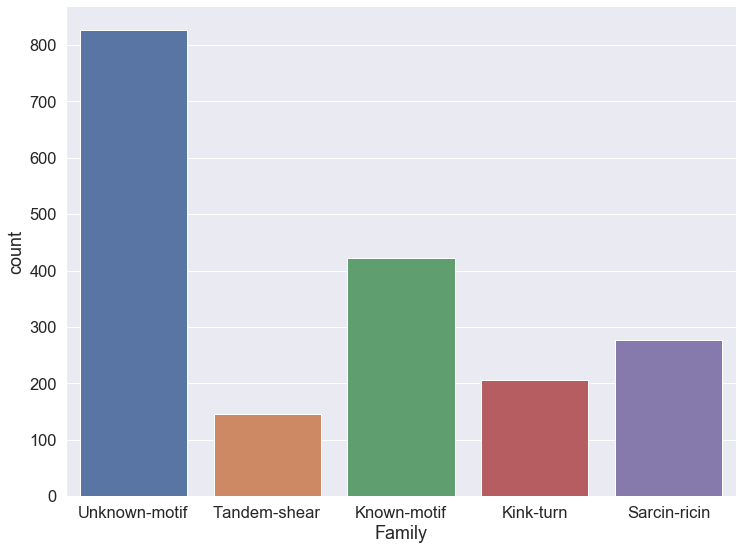

In [2631]:

check_class_bias()
Data = Data.drop('Family', axis = 1)

### Checking correlation among features

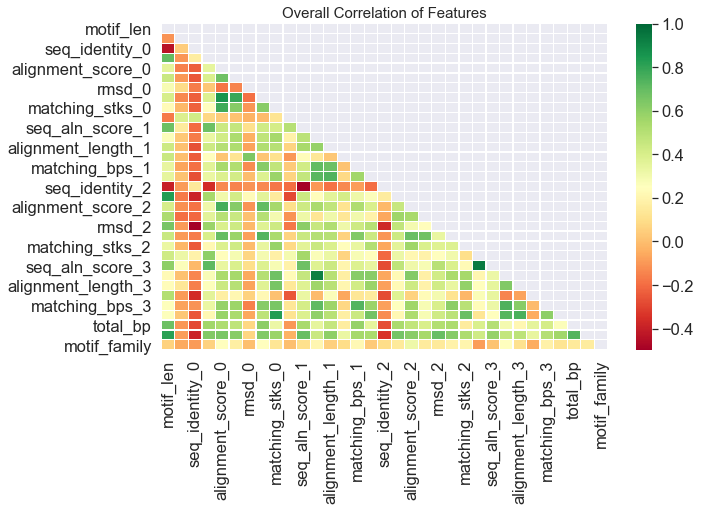

In [2632]:

correlation_check()

### Checking if the numerical features are normalized or not

In [2633]:
skewed_column = skewness_check()

{'motif_len': 1.111778009030764, 'gc_percentage': -0.10693365247785935, 'seq_identity_0': 0.6237517410961652, 'seq_aln_score_0': 0.4314573945583923, 'alignment_score_0': 2.055538974884099, 'alignment_length_0': 1.0064275628352732, 'rmsd_0': -0.2593866952707174, 'matching_bps_0': 1.549830648504528, 'matching_stks_0': 0.6524407391528452, 'seq_identity_1': 0.007383739955851592, 'seq_aln_score_1': 0.4042284758323105, 'alignment_score_1': 1.2909348141107533, 'alignment_length_1': 1.0946027818763344, 'rmsd_1': -0.08509741653333301, 'matching_bps_1': 0.464844175683471, 'matching_stks_1': 0.9205081636219298, 'seq_identity_2': 0.09901945068453807, 'seq_aln_score_2': 2.024007689191799, 'alignment_score_2': 1.3430956819442805, 'alignment_length_2': 2.450330871870475, 'rmsd_2': -0.4840849805386883, 'matching_bps_2': 1.2846427566970537, 'matching_stks_2': 0.5041832588289831, 'seq_identity_3': 0.156858516944559, 'seq_aln_score_3': 0.25102694525129415, 'alignment_score_3': 0.7239394437231981, 'alignm

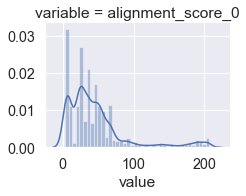

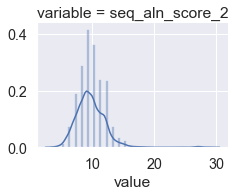

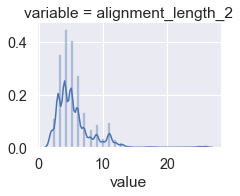

In [2634]:
skewness_plot(skewed_column)

In [2635]:
# skewed_column.remove('matching_bps_0')
# skewed_column.remove('matching_bps_2')
print(skewed_column)
# skew_log_ransform(skewed_column)

['alignment_score_0', 'seq_aln_score_2', 'alignment_length_2']


### Feature Importance Generation

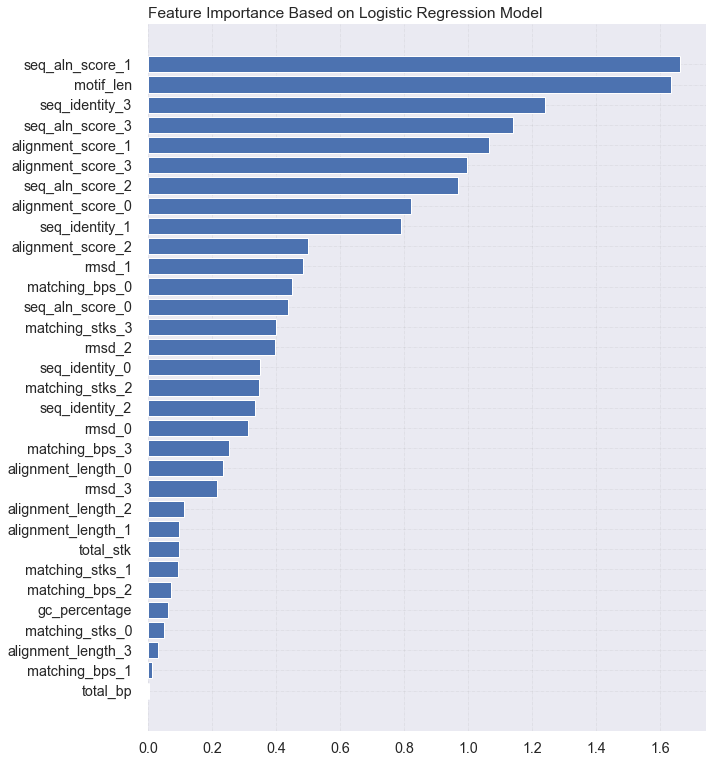

In [2636]:
### Logistic Regression Feature Importance
LR_imp_feature_list = {}
model = LogisticRegression(multi_class = 'multinomial', max_iter = 200)

# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# x = scaler.transform(X)
# x_train = scaler.fit_transform(x)
# fit the model
model.fit(X_scaled, Y)

# get importance
importance = model.coef_[0]
# summarize feature importance

cols = X.columns

for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
  LR_imp_feature_list[cols[i]] = abs(v)
  # print('Feature: %0d, Score: %.5f' % (i,v))

# print(LR_imp_feature_list)
# plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

sorted_LR_imp_feature_list = sorted(LR_imp_feature_list.items(), key=lambda item: item[1], reverse=True)
# print(sorted_LR_imp_feature_list)

## Plotting Barplot of Decision Tree

features_sorted = []
importance_sorted = []

for i in sorted_LR_imp_feature_list:
    features_sorted += [i[0]]
    importance_sorted += [i[1]]

# print(features_sorted)
# print(importance_sorted)
fig, ax = plt.subplots(figsize =(10, 13))

# Horizontal Bar Plot
ax.barh(features_sorted,importance_sorted)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Increase Fontsize
ax.set_xlabel(xlabel = None, fontsize=20)
ax.set_ylabel(ylabel = None, fontsize=20)


# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')
 
# Add Plot Title
ax.set_title('Feature Importance Based on Logistic Regression Model',
             loc ='left', )


# Show Plot
plt.show()

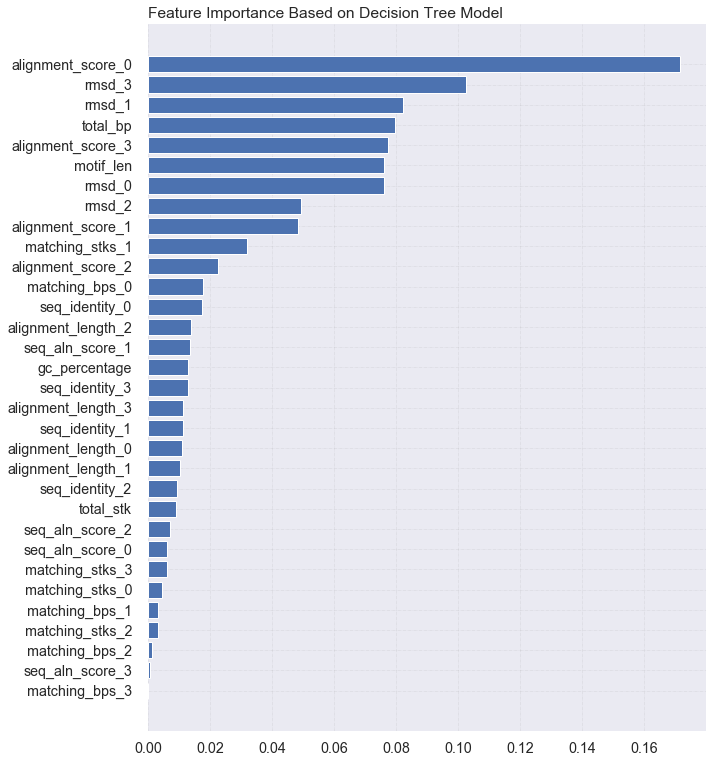

In [2637]:
### Decision Tree Feature Importance
DT_imp_feature_list = {}

model = DecisionTreeClassifier()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance

cols = X.columns

for i,v in enumerate(importance):
  DT_imp_feature_list[cols[i]] = v
#   print('Feature: %0d, Score: %.5f' % (i,v))
 
# print(DT_imp_feature_list)
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

sorted_DT_imp_feature_list = sorted(DT_imp_feature_list.items(), key=lambda item: item[1], reverse=True)
# print(sorted_DT_imp_feature_list)

## Plotting Barplot of Decision Tree

features_sorted = []
importance_sorted = []

for i in sorted_DT_imp_feature_list:
    features_sorted += [i[0]]
    importance_sorted += [i[1]]

# print(features_sorted)
# print(importance_sorted)
fig, ax = plt.subplots(figsize =(10, 13))

# Horizontal Bar Plot
ax.barh(features_sorted,importance_sorted)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Increase Fontsize
ax.set_xlabel(xlabel = None, fontsize=20)
ax.set_ylabel(ylabel = None, fontsize=20)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')
 
# Add Plot Title
ax.set_title('Feature Importance Based on Decision Tree Model',loc ='left', )
  
# Show Plot
plt.show()

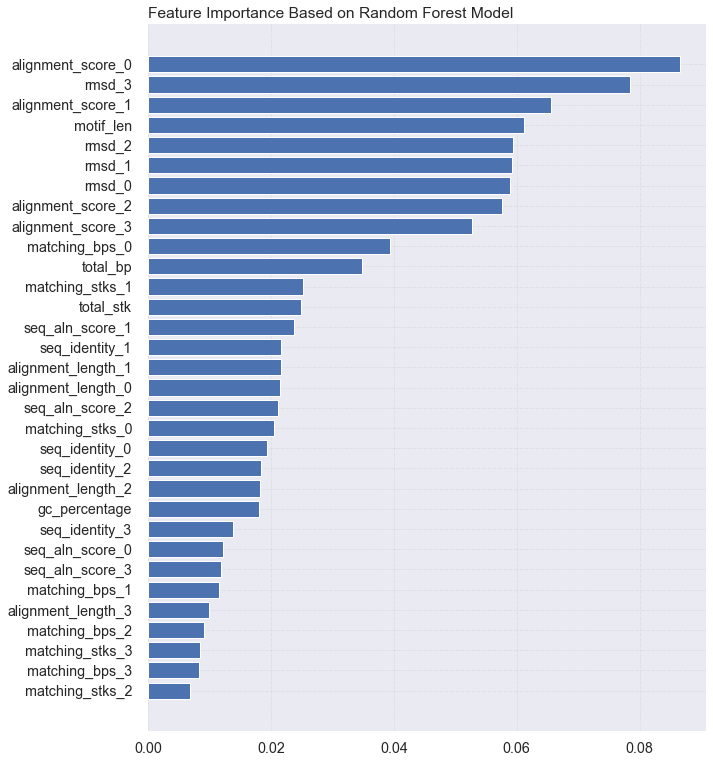

In [2638]:
## Random Forest Feature Importance
RT_imp_feature_list = {}

model = RandomForestClassifier()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
cols = X.columns


for i,v in enumerate(importance):
  RT_imp_feature_list[cols[i]] = v
#   print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance

# print(RT_imp_feature_list)
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()


sorted_RT_imp_feature_list = sorted(RT_imp_feature_list.items(), key=lambda item: item[1], reverse=True)
# print(sorted_RT_imp_feature_list)


# Plotting Barplot of Random forest

features_sorted = []
importance_sorted = []

for i in sorted_RT_imp_feature_list:
    features_sorted += [i[0]]
    importance_sorted += [i[1]]

# print(features_sorted)
# print(importance_sorted)
fig, ax = plt.subplots(figsize =(10, 13))

# Horizontal Bar Plot
ax.barh(features_sorted,importance_sorted)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Increase Fontsize
ax.set_xlabel(xlabel = None, fontsize=20)
ax.set_ylabel(ylabel = None, fontsize=20)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add Plot Title
ax.set_title('Feature Importance Based on Random Forest Model',loc ='left', )
  
# Show Plot
plt.show()

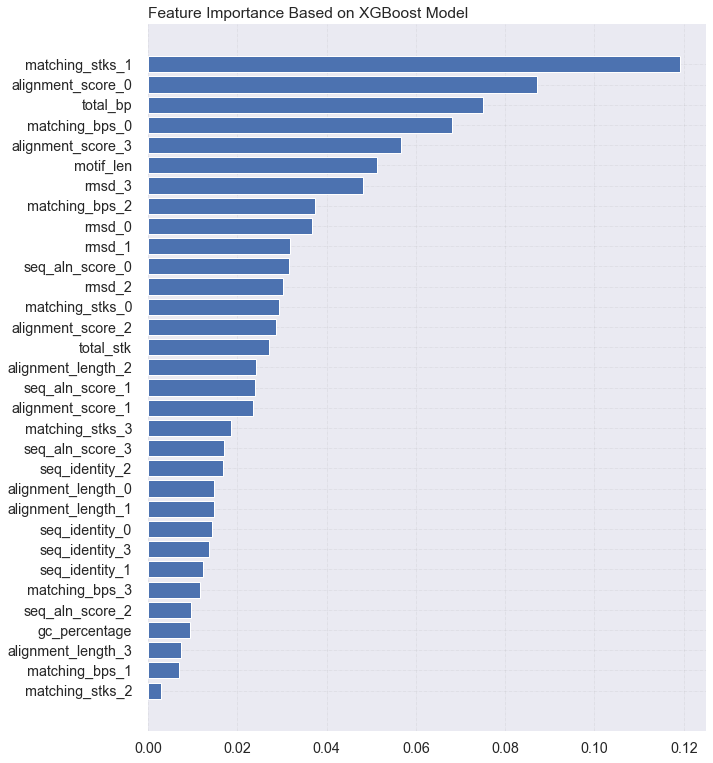

In [2639]:
## XGBoost Feature Importance
XG_imp_feature_list = {}

model = XGBClassifier()
# fit the model
model.fit(X, Y)
# g

importance = model.feature_importances_
# summarize feature importance
cols = X.columns

for i,v in enumerate(importance):
  XG_imp_feature_list[cols[i]] = v
#   print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

# print(XG_imp_feature_list)
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

sorted_XG_imp_feature_list = sorted(XG_imp_feature_list.items(), key=lambda item: item[1], reverse=True)
# print(sorted_XG_imp_feature_list)

# Plotting Barplot of XGBoost
features_sorted = []
importance_sorted = []

for i in sorted_XG_imp_feature_list:
    features_sorted += [i[0]]
    importance_sorted += [i[1]]

# print(features_sorted)
# print(importance_sorted)
fig, ax = plt.subplots(figsize =(10, 13))

# Horizontal Bar Plot
ax.barh(features_sorted,importance_sorted)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Increase Fontsize
ax.set_xlabel(xlabel = None, fontsize=20)
ax.set_ylabel(ylabel = None, fontsize=20)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add Plot Title
ax.set_title('Feature Importance Based on XGBoost Model',loc ='left', )
 
# Show Plot
plt.show()

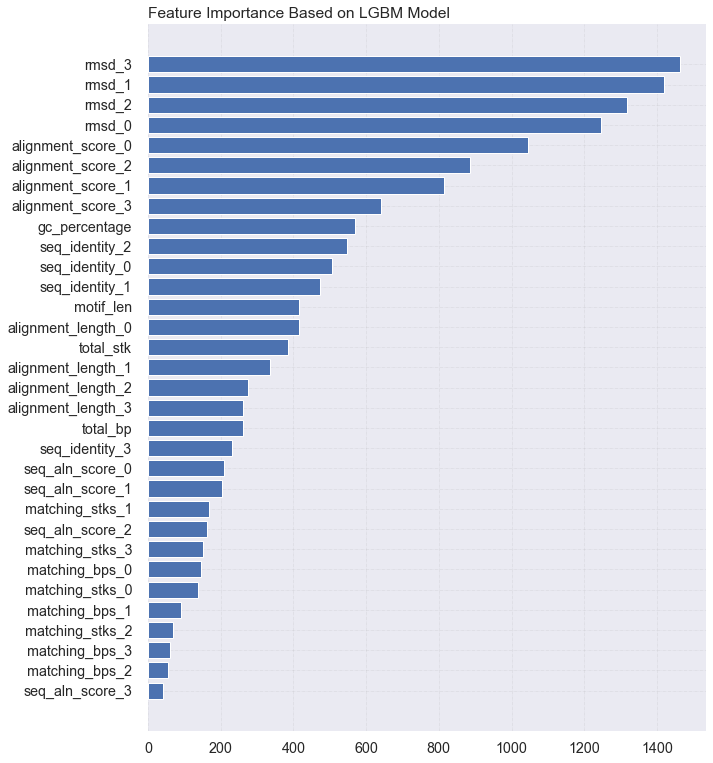

In [2640]:
## LGBoost Feature Importance
LG_imp_feature_list = {}

model = lgb.LGBMClassifier()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
  LG_imp_feature_list[cols[i]] = v
#   print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

# print(LG_imp_feature_list)
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

sorted_LG_imp_feature_list = sorted(LG_imp_feature_list.items(), key=lambda item: item[1], reverse=True)
# print(sorted_LG_imp_feature_list)

# Plotting Barplot of XGBoost
features_sorted = []
importance_sorted = []

for i in sorted_LG_imp_feature_list:
    features_sorted += [i[0]]
    importance_sorted += [i[1]]

fig, ax = plt.subplots(figsize =(10, 13))

# Horizontal Bar Plot
ax.barh(features_sorted,importance_sorted)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Increase Fontsize
ax.set_xlabel(xlabel = None, fontsize=20)
ax.set_ylabel(ylabel = None, fontsize=20)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add Plot Title
ax.set_title('Feature Importance Based on LGBM Model',loc ='left', )
  
# Show Plot
plt.show()

In [2641]:
Final_LR_imp_feature_list = []
for i in range(0, len(sorted_DT_imp_feature_list)):
  if(sorted_LR_imp_feature_list[i][1] > 0.05):
    Final_LR_imp_feature_list.append(sorted_LR_imp_feature_list[i][0])

Final_DT_imp_feature_list = []
for i in range(0, len(sorted_DT_imp_feature_list)):
  if(sorted_DT_imp_feature_list[i][1] > 0.005):
    Final_DT_imp_feature_list.append(sorted_DT_imp_feature_list[i][0])

Final_RT_imp_feature_list = []
for i in range(0, len(sorted_RT_imp_feature_list)):
  if(sorted_RT_imp_feature_list[i][1] > 0.01):
    Final_RT_imp_feature_list.append(sorted_RT_imp_feature_list[i][0])

Final_XG_imp_feature_list = []
for i in range(0, len(sorted_XG_imp_feature_list)):
  if(sorted_XG_imp_feature_list[i][1] > 0.01):
    Final_XG_imp_feature_list.append(sorted_XG_imp_feature_list[i][0])

Final_LG_imp_feature_list = []
for i in range(0, len(sorted_LG_imp_feature_list)):
  if(sorted_LG_imp_feature_list[i][1] > 100):
    Final_LG_imp_feature_list.append(sorted_LG_imp_feature_list[i][0])

# print(Final_LR_imp_feature_list)
# print(Final_DT_imp_feature_list)
# print(Final_RT_imp_feature_list)
# print(Final_XG_imp_feature_list)
# print(Final_LG_imp_feature_list)

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

temp_intersec1 = intersection(Final_DT_imp_feature_list, Final_RT_imp_feature_list)
temp_intersec2 = intersection(temp_intersec1, Final_XG_imp_feature_list)
temp_intersec3 = intersection(temp_intersec2, Final_LR_imp_feature_list)
final_intersec = intersection(temp_intersec3, Final_LG_imp_feature_list)

print('Number of Common Important Features: ', len(final_intersec))
print('List of Common Important Features: ', final_intersec)


Number of Common Important Features:  21
List of Common Important Features:  ['alignment_score_0', 'rmsd_3', 'rmsd_1', 'alignment_score_3', 'motif_len', 'rmsd_0', 'rmsd_2', 'alignment_score_1', 'matching_stks_1', 'alignment_score_2', 'matching_bps_0', 'seq_identity_0', 'alignment_length_2', 'seq_aln_score_1', 'seq_identity_3', 'seq_identity_1', 'alignment_length_0', 'alignment_length_1', 'seq_identity_2', 'total_stk', 'seq_aln_score_0']


In [2642]:
## List of Less important features

Final_LR_non_imp_feature_list = []
for i in range(15, len(sorted_LR_imp_feature_list)):
  Final_LR_non_imp_feature_list.append(sorted_LR_imp_feature_list[i][0])

Final_DT_non_imp_feature_list = []
for i in range(15, len(sorted_DT_imp_feature_list)):
  Final_DT_non_imp_feature_list.append(sorted_DT_imp_feature_list[i][0])

Final_RT_non_imp_feature_list = []
for i in range(15, len(sorted_RT_imp_feature_list)):
  Final_RT_non_imp_feature_list.append(sorted_RT_imp_feature_list[i][0])

Final_XG_non_imp_feature_list = []
for i in range(15, len(sorted_XG_imp_feature_list)):
  Final_XG_non_imp_feature_list.append(sorted_XG_imp_feature_list[i][0])

Final_LG_non_imp_feature_list = []
for i in range(15, len(sorted_LG_imp_feature_list)):
  Final_LG_non_imp_feature_list.append(sorted_LG_imp_feature_list[i][0])

# print(Final_DT_non_imp_feature_list)
# print(Final_RT_non_imp_feature_list)
# print(Final_XG_non_imp_feature_list)
# print(Final_LG_non_imp_feature_list)

In [2643]:
temp_intersec1 = intersection(Final_DT_non_imp_feature_list, Final_RT_non_imp_feature_list)
temp_intersec2 = intersection(temp_intersec1, Final_XG_non_imp_feature_list)
final_intersec = intersection(temp_intersec2, Final_LG_non_imp_feature_list)
print(final_intersec)
len(final_intersec)

['seq_identity_3', 'alignment_length_3', 'alignment_length_1', 'seq_aln_score_2', 'matching_stks_3', 'matching_bps_1', 'matching_stks_2', 'seq_aln_score_3', 'matching_bps_3']


9

## Condition 1: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Known-motif', 'Unknown-motif' without bias handling

In [2644]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


In [2645]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2646]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 1: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 1: Random forest Accuracy ----------
88.29787234042553
87.50728888654
84.42047516864048
85.79762610706126
[0.69 0.85 0.74 0.75 0.79 0.74 0.85 0.76 0.83 0.68]
Accuracy of Model with Cross Validation is: 76.92940038684719


In [2647]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 1: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 1: XGBoost Accuracy ----------
84.9290780141844
85.64413510831731
81.2892866309603
83.27426943349231
Accuracy of Model with Cross Validation is: 73.94129024917511


## Condition 2: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Known-motif', 'Unknown-motif' with bias handling

In [2648]:
Balance_Data = Data.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))


In [2649]:
mapp = {0 : 'Unknown motif family', 1: 'Kink-turn', 2: 'Sarcin-ricin', 3: 'Tandem-shear', 4: 'Known motif family'}
Balance_Data['Family'] = Balance_Data["motif_family"].copy()
Balance_Data.Family = [mapp[item] for item in Balance_Data.Family]
item_counts = Balance_Data["Family"].value_counts()
print(item_counts)
print ('----------------------------')
Balance_Data = Balance_Data.drop('Family', axis = 1)

Kink-turn               146
Known motif family      146
Sarcin-ricin            146
Unknown motif family    146
Tandem-shear            146
Name: Family, dtype: int64
----------------------------


In [2650]:
X = Balance_Data.drop('motif_family', axis = 1)
Y = Balance_Data['motif_family']

In [2651]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2652]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2653]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 2: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 2: Random forest Accuracy ----------
84.47488584474885
84.14116866258698
84.08470730896362
83.93335139267187
[0.86 0.85 0.84 0.82 0.85 0.79 0.81 0.89 0.95 0.82]
Accuracy of Model with Cross Validation is: 84.79452054794521


In [2654]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 2: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 2: XGBoost Accuracy ----------
83.56164383561644
83.42118863049095
83.67108685872986
83.31920151357195
Accuracy of Model with Cross Validation is: 83.56164383561644


## Condition 3: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Known-motif' without bias handling

In [2655]:
### Drop class 0
Data_1234 = Data[Data["motif_family"] != 0]
# print(Data_1234.shape)
# print(Data_1234["motif_family"].unique())
X = Data_1234.drop('motif_family', axis = 1)
Y = Data_1234['motif_family']

In [2656]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2657]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2658]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 3: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 3: Random forest Accuracy ----------
90.50632911392405
91.41760744701921
87.89348655862149
89.34539603488862
[0.73 0.93 0.79 0.88 0.89 0.96 0.87 0.8  0.83 0.59]
Accuracy of Model with Cross Validation is: 82.59748427672955


In [2659]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 3: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 3: XGBoost Accuracy ----------
92.08860759493672
93.41073753288047
89.70265784044092
91.28973637792342
Accuracy of Model with Cross Validation is: 81.92722371967655


## Condition 4: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Known-motif' with bias handling

In [2660]:
### Drop class 0
Data_1234 = Data[Data["motif_family"] != 0]
# print(Data_1234.shape)
# print(Data_1234["motif_family"].unique())

### Balancing Data
Balance_Data = Data_1234.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
Y = Balance_Data['motif_family']

In [2661]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2662]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2663]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 4: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 4: Random forest Accuracy ----------
89.20454545454545
89.65938701061819
89.2192162568744
89.29213305222495
[0.93 0.92 0.93 0.85 0.97 0.79 0.86 0.84 0.83 0.88]
Accuracy of Model with Cross Validation is: 87.99532437171244


In [2664]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 4: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 4: XGBoost Accuracy ----------
89.77272727272727
90.29631546731409
89.70597302029643
89.84636256442118
Accuracy of Model with Cross Validation is: 87.66803039158387


## Condition 5: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Unknown-motif' without bias handling

In [2665]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
# print(Data_0123.shape)
# print(Data_0123["motif_family"].unique())
X = Data_0123.drop('motif_family', axis = 1)
Y = Data_0123['motif_family']

In [2666]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2667]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2668]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 5: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 5: Random forest Accuracy ----------
92.44851258581235
92.39813106601427
87.47108004385964
89.71843464056812
[0.82 0.92 0.92 0.86 0.9  0.92 0.91 0.87 0.87 0.77]
Accuracy of Model with Cross Validation is: 87.6254133207369


In [2669]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 5: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 5: XGBoost Accuracy ----------
90.61784897025171
88.03601788882318
85.48718475877193
86.5863905867768
Accuracy of Model with Cross Validation is: 86.31695795937647


## Condition 6: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear', 'Unknown-motif' with bias handling

In [2670]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
# print(Data_1234.shape)
# print(Data_1234["motif_family"].unique())

### Balancing Data
Balance_Data = Data_0123.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
Y = Balance_Data['motif_family']

In [2671]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2672]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2673]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 6: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 6: Random forest Accuracy ----------
86.36363636363636
86.89892053675588
86.4071863671114
86.371639394607
[0.85 0.93 0.9  0.88 0.86 0.9  0.9  0.84 0.88 0.81]
Accuracy of Model with Cross Validation is: 87.48977206312098


In [2674]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 6: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 6: XGBoost Accuracy ----------
85.22727272727273
85.99700876306034
85.25395200868086
85.30072703238598
Accuracy of Model with Cross Validation is: 87.13909994155465


## Condition 7: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear' without bias handling

In [2675]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
Data_123 = Data_0123[Data_0123["motif_family"] != 0]
# print(Data_123.shape)
# print(Data_123["motif_family"].unique())
X = Data_123.drop('motif_family', axis = 1)
Y = Data_123['motif_family']

In [2676]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2677]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2678]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 7: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 7: Random forest Accuracy ----------
92.06349206349206
93.07846076961518
91.56565656565657
92.18302754927129
[0.84 0.95 0.95 0.9  0.89 0.98 0.89 0.95 0.9  0.76]
Accuracy of Model with Cross Validation is: 90.27905785970303


In [2679]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 7: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 7: XGBoost Accuracy ----------
92.5925925925926
93.15510783933875
92.86195286195286
92.96914133116262
Accuracy of Model with Cross Validation is: 89.63901689708142


## Condition 8: Considering features 'Kink-turn', 'Sarcin-ricin', 'Tandem-shear' with bias handling

In [2680]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
Data_123 = Data_0123[Data_0123["motif_family"] != 0]
# print(Data_123.shape)
# print(Data_123["motif_family"].unique())

Balance_Data = Data_123.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
Y = Balance_Data['motif_family']

In [2681]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2682]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2683]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 8: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 8: Random forest Accuracy ----------
92.42424242424242
92.88806431663575
92.56863438199599
92.50036856848001
[0.91 0.91 0.95 0.98 0.91 0.98 0.91 0.86 0.93 0.93]
Accuracy of Model with Cross Validation is: 92.6955602536998


In [2684]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 8: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)


### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 8: XGBoost Accuracy ----------
93.18181818181817
94.22839506172839
93.18879855465222
93.28752045217908
Accuracy of Model with Cross Validation is: 91.99260042283296


## Selected condition (Condition 8) after excluding less important features

In [2685]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
Data_123 = Data_0123[Data_0123["motif_family"] != 0]
# print(Data_123.shape)
# print(Data_123["motif_family"].unique())

Balance_Data = Data_123.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
# useless_cols = ['alignment_length_3', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
useless_cols = ['seq_aln_score_1', 'alignment_length_3', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
#useless_cols = ['seq_aln_score_1', 'alignment_length_2', 'alignment_length_3', 'seq_aln_score_2', 'alignment_length_1', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
#
X.drop(useless_cols, axis=1, inplace=True)
Y = Balance_Data['motif_family']

In [2686]:
# Feature Scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [2687]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 0)

In [2688]:
### Random Forest
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 42)
# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)
# Probabilities for each class
rf_probs = model.predict_proba(x_test)[:, 1]

### Accuracy Check
print("---------- Condition 8 without less important features: Random forest Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)

### K-fold cross validation
accuracy = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

---------- Condition 8 without less important features: Random forest Accuracy ----------
90.9090909090909
90.82176825868068
90.92651506225208
90.81872274308313
[0.95 0.91 0.95 0.93 0.98 0.98 0.93 0.93 0.91 0.95]
Accuracy of Model with Cross Validation is: 94.28646934460888


In [2689]:
### XGB Classifier
model = XGBClassifier()

# Fitting Random Forest Classification to the Training set
model.fit(x_train, y_train)

# Actual class predictions
y_predict = model.predict(x_test)

### Accuracy Check
print("---------- Condition 8 without less important features: XGBoost Accuracy ----------")
accuracy = accuracy_score(y_test, y_predict)*100
print(accuracy)
precision = precision_score(y_test, y_predict, average='macro') * 100
print(precision)
recall = recall_score(y_test, y_predict, average='macro') * 100
print(recall)
score = f1_score(y_test, y_predict, average='macro') * 100
print(score)


### K-fold cross validation
n_scores = cross_val_score(model, X_scaled, Y, scoring='accuracy', cv = 10)
print("Accuracy of Model with Cross Validation is:",n_scores.mean() * 100)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

---------- Condition 8 without less important features: XGBoost Accuracy ----------
89.39393939393939
89.44131234828909
89.49334275951455
89.3731892569102
Accuracy of Model with Cross Validation is: 93.84249471458773


# Implementing Binary Classifier based on Naive Bayes in Condition 8 and without excluding less important features

In [2690]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
Data_123 = Data_0123[Data_0123["motif_family"] != 0]
# print(Data_123.shape)
# print(Data_123["motif_family"].unique())

Balance_Data = Data_123.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
Y = Balance_Data['motif_family']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [2691]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [2692]:
def binary_classfier():
    
    y_train_temp = y_train.copy()
    y_test_temp = y_test.copy()
    
    
    print("------------------------------------------------------------")
    ##### Kink-turn #####
    kink_map = {1:11, 2:0, 3:0}
    y_train_kink = y_train_temp.map(kink_map).astype('int32')
    y_test_kink = y_test_temp.map(kink_map).astype('int32')

    model_kink = GaussianNB()
    model_kink.fit(x_train, y_train_kink)
    y_pred_kink = model_kink.predict(x_test)
    y_pred_kink_prob = model_kink.predict_proba(x_test)

    accuracy = accuracy_score(y_test_kink, y_pred_kink)*100
    print("Kink-turn: ", accuracy)
    precision = precision_score(y_test_kink, y_pred_kink, average='macro') * 100
    recall = recall_score(y_test_kink, y_pred_kink, average='macro') * 100
    score = f1_score(y_test_kink, y_pred_kink, average='macro') * 100
    
    
    ##### Sarcin-ricin #####
    sarcin_map = {2:12, 1:0, 3:0}
    y_train_sarcin = y_train_temp.map(sarcin_map).astype('int32')
    y_test_sarcin = y_test_temp.map(sarcin_map).astype('int32')

    model_sarcin = GaussianNB()
    model_sarcin.fit(x_train, y_train_sarcin)
    y_pred_sarcin = model_sarcin.predict(x_test)
    y_pred_sarcin_prob = model_sarcin.predict_proba(x_test)

    accuracy = accuracy_score(y_test_sarcin, y_pred_sarcin)*100
    print("Sarcin-ricin: ", accuracy)
    precision = precision_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100
    recall = recall_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100
    score = f1_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100

    
    ##### Tandem-shear #####
    tandem_map = {3:13, 1:0, 2:0}
    y_train_tandem = y_train_temp.map(tandem_map).astype('int32')
    y_test_tandem = y_test_temp.map(tandem_map).astype('int32')

    model_tandem = GaussianNB()
    model_tandem.fit(x_train, y_train_tandem)
    y_pred_tandem = model_tandem.predict(x_test)
    y_pred_tandem_prob = model_tandem.predict_proba(x_test)

    accuracy = accuracy_score(y_test_tandem, y_pred_tandem)*100
    print("Tandem-shear: ", accuracy)
    precision = precision_score(y_test_tandem, y_pred_tandem, average='macro') * 100
    recall = recall_score(y_test_tandem, y_pred_tandem, average='macro') * 100
    score = f1_score(y_test_tandem, y_pred_tandem, average='macro') * 100

    
    
    ##### Final Predictor #####
    y_predict = []

    for i in range(0, len(y_pred_kink)):
        tot = y_pred_kink[i] + y_pred_sarcin[i] + y_pred_tandem[i]
        probab = [0, 0, 0]
        if tot > 13:
            if y_pred_kink[i] > 0:
                probab[0] = y_pred_kink_prob[i][1]
            if y_pred_sarcin[i] > 0:
                probab[1] = y_pred_sarcin_prob[i][1]
            if y_pred_tandem[i] > 0:
                probab[2] = y_pred_tandem_prob[i][1]

            max_prob = max(probab)
            for k in range(0, 3):
                if probab[k] == max_prob:
                    max_index = k

            if max_index == 0:
                y_predict.append(1)
            elif max_index == 1:
                y_predict.append(2)
            elif max_index == 2:
                y_predict.append(3)


        elif tot == 0:
            probab[0] = y_pred_kink_prob[i][1]
            probab[1] = y_pred_sarcin_prob[i][1]
            probab[2] = y_pred_tandem_prob[i][1]     

            max_prob = max(probab)
            for k in range(0, 3):
                if probab[k] == max_prob:
                    max_index = k

            if max_index == 0:
                y_predict.append(1)
            elif max_index == 1:
                y_predict.append(2)
            elif max_index == 2:
                y_predict.append(3)


        else:
            if tot == 11:
                y_predict.append(1)
            elif tot == 12:
                y_predict.append(2)
            elif tot == 13:
                y_predict.append(3)

    
    accuracy = accuracy_score(y_test, y_predict)*100
    print("Binary Classifier: ", accuracy)
    precision = precision_score(y_test, y_predict, average='macro') * 100
    recall = recall_score(y_test, y_predict, average='macro') * 100
    score = f1_score(y_test, y_predict, average='macro') * 100


    ### Plotting Confusion Matrix
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, classes=[1, 2, 3],normalize=True, title='Confusion matrix')
    print("------------------------------------------------------------")
    
    return accuracy, precision, recall, score

In [2693]:
def cross_validation_result(k = 5):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    for i in range(0, k):
        accuracy, precision, recall, f1_score = binary_classfier()
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        
    print("Accuracy of Model with Cross Validation is:",statistics.mean(accuracy_list))
    print("Precision of Model with Cross Validation is:",statistics.mean(precision_list))
    print("Recall of Model with Cross Validation is:",statistics.mean(recall_list))
    print("F1_score of Model with Cross Validation is:",statistics.mean(f1_score_list))

------------------------------------------------------------
Kink-turn:  87.12121212121212
Sarcin-ricin:  91.66666666666666
Tandem-shear:  95.45454545454545
Binary Classifier:  87.12121212121212
Normalized confusion matrix
[[0.87 0.11 0.02]
 [0.17 0.8  0.02]
 [0.07 0.   0.93]]
------------------------------------------------------------
------------------------------------------------------------
Kink-turn:  87.12121212121212
Sarcin-ricin:  91.66666666666666
Tandem-shear:  95.45454545454545
Binary Classifier:  87.12121212121212
Normalized confusion matrix
[[0.87 0.11 0.02]
 [0.17 0.8  0.02]
 [0.07 0.   0.93]]
------------------------------------------------------------
------------------------------------------------------------
Kink-turn:  87.12121212121212
Sarcin-ricin:  91.66666666666666
Tandem-shear:  95.45454545454545
Binary Classifier:  87.12121212121212
Normalized confusion matrix
[[0.87 0.11 0.02]
 [0.17 0.8  0.02]
 [0.07 0.   0.93]]
--------------------------------------------

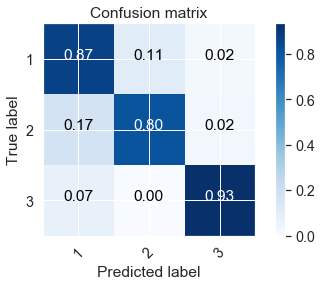

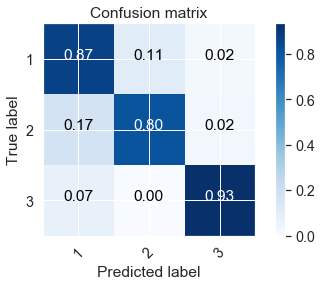

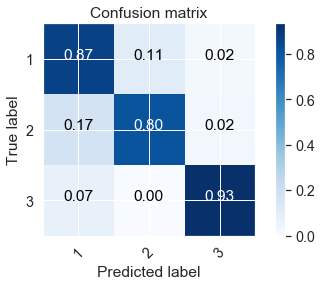

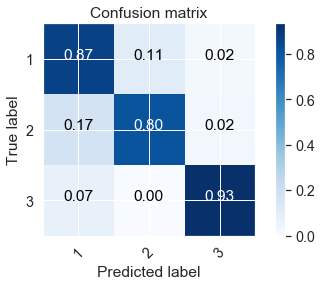

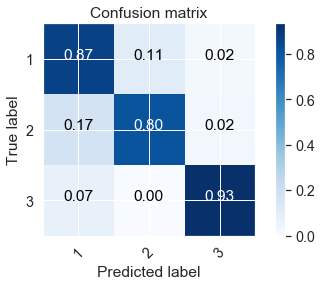

In [2694]:
cross_validation_result(k = 5)

## Implementing Binary Classifier based on Naive Bayes in Condition 8 after excluding less important features

In [2695]:
### Drop class 0
Data_0123 = Data[Data["motif_family"] != 4]
Data_123 = Data_0123[Data_0123["motif_family"] != 0]
# print(Data_123.shape)
# print(Data_123["motif_family"].unique())

Balance_Data = Data_123.groupby('motif_family')
Balance_Data = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))

X = Balance_Data.drop('motif_family', axis = 1)
#useless_cols = ['alignment_length_3', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
useless_cols = ['seq_aln_score_1', 'alignment_length_3', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
#useless_cols = ['seq_aln_score_1', 'alignment_length_2', 'alignment_length_3', 'seq_aln_score_2', 'alignment_length_1', 'matching_stks_3', 'seq_aln_score_3', 'matching_bps_1', 'matching_bps_3', 'matching_stks_2']
#
X.drop(useless_cols, axis=1, inplace=True)
Y = Balance_Data['motif_family']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [2696]:
def binary_classfier():
    
    y_train_temp = y_train.copy()
    y_test_temp = y_test.copy()
    
    print("------------------------------------------------------------")
    ##### Kink-turn #####
    kink_map = {1:11, 2:0, 3:0}
    y_train_kink = y_train_temp.map(kink_map).astype('int32')
    y_test_kink = y_test_temp.map(kink_map).astype('int32')

    model_kink = GaussianNB()
    model_kink.fit(x_train, y_train_kink)
    y_pred_kink = model_kink.predict(x_test)
    y_pred_kink_prob = model_kink.predict_proba(x_test)

    accuracy = accuracy_score(y_test_kink, y_pred_kink)*100
    print("Kink-turn: ", accuracy)
    precision = precision_score(y_test_kink, y_pred_kink, average='macro') * 100
    recall = recall_score(y_test_kink, y_pred_kink, average='macro') * 100
    score = f1_score(y_test_kink, y_pred_kink, average='macro') * 100
 
        
    ##### Sarcin-ricin #####
    sarcin_map = {2:12, 1:0, 3:0}
    y_train_sarcin = y_train_temp.map(sarcin_map).astype('int32')
    y_test_sarcin = y_test_temp.map(sarcin_map).astype('int32')

    model_sarcin = GaussianNB()
    model_sarcin.fit(x_train, y_train_sarcin)
    y_pred_sarcin = model_sarcin.predict(x_test)
    y_pred_sarcin_prob = model_sarcin.predict_proba(x_test)

    accuracy = accuracy_score(y_test_sarcin, y_pred_sarcin)*100
    print("Sarcin-ricin: ", accuracy)
    precision = precision_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100
    recall = recall_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100
    score = f1_score(y_test_sarcin, y_pred_sarcin, average='macro') * 100

    
    ##### Tandem-shear #####
    tandem_map = {3:13, 1:0, 2:0}
    y_train_tandem = y_train_temp.map(tandem_map).astype('int32')
    y_test_tandem = y_test_temp.map(tandem_map).astype('int32')

    model_tandem = GaussianNB()
    model_tandem.fit(x_train, y_train_tandem)
    y_pred_tandem = model_tandem.predict(x_test)
    y_pred_tandem_prob = model_tandem.predict_proba(x_test)

    accuracy = accuracy_score(y_test_tandem, y_pred_tandem)*100
    print("Tandem-shear: ", accuracy)
    precision = precision_score(y_test_tandem, y_pred_tandem, average='macro') * 100
    recall = recall_score(y_test_tandem, y_pred_tandem, average='macro') * 100
    score = f1_score(y_test_tandem, y_pred_tandem, average='macro') * 100

       
    ##### Final Predictor #####
    y_predict = []

    for i in range(0, len(y_pred_kink)):
        tot = y_pred_kink[i] + y_pred_sarcin[i] + y_pred_tandem[i]
        probab = [0, 0, 0]
        if tot > 13:
            if y_pred_kink[i] > 0:
                probab[0] = y_pred_kink_prob[i][1]
            if y_pred_sarcin[i] > 0:
                probab[1] = y_pred_sarcin_prob[i][1]
            if y_pred_tandem[i] > 0:
                probab[2] = y_pred_tandem_prob[i][1]

            max_prob = max(probab)
            for k in range(0, 3):
                if probab[k] == max_prob:
                    max_index = k

            if max_index == 0:
                y_predict.append(1)
            elif max_index == 1:
                y_predict.append(2)
            elif max_index == 2:
                y_predict.append(3)


        elif tot == 0:
            probab[0] = y_pred_kink_prob[i][1]
            probab[1] = y_pred_sarcin_prob[i][1]
            probab[2] = y_pred_tandem_prob[i][1]     

            max_prob = max(probab)
            for k in range(0, 3):
                if probab[k] == max_prob:
                    max_index = k

            if max_index == 0:
                y_predict.append(1)
            elif max_index == 1:
                y_predict.append(2)
            elif max_index == 2:
                y_predict.append(3)


        else:
            if tot == 11:
                y_predict.append(1)
            elif tot == 12:
                y_predict.append(2)
            elif tot == 13:
                y_predict.append(3)

    
    accuracy = accuracy_score(y_test, y_predict)*100
    print("Binary Classifier: ", accuracy)
    precision = precision_score(y_test, y_predict, average='macro') * 100
    recall = recall_score(y_test, y_predict, average='macro') * 100
    score = f1_score(y_test, y_predict, average='macro') * 100


    ### Plotting Confusion Matrix
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, classes=[1, 2, 3],normalize=True, title='Confusion matrix')
    print("------------------------------------------------------------")
    
    return accuracy, precision, recall, score

In [2697]:
def cross_validation_result(k = 5):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    for i in range(0, k):
        accuracy, precision, recall, f1_score = binary_classfier()
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
     
    print("------------------------------------------------------------")
    print("Accuracy of Model with Cross Validation is:",statistics.mean(accuracy_list))
    print("Precision of Model with Cross Validation is:",statistics.mean(precision_list))
    print("Recall of Model with Cross Validation is:",statistics.mean(recall_list))
    print("F1_score of Model with Cross Validation is:",statistics.mean(f1_score_list))
    print("------------------------------------------------------------")

------------------------------------------------------------
Kink-turn:  95.45454545454545
Sarcin-ricin:  94.6969696969697
Tandem-shear:  94.6969696969697
Binary Classifier:  92.42424242424242
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.12 0.85 0.02]
 [0.07 0.02 0.91]]
------------------------------------------------------------
------------------------------------------------------------
Kink-turn:  95.45454545454545
Sarcin-ricin:  94.6969696969697
Tandem-shear:  94.6969696969697
Binary Classifier:  92.42424242424242
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.12 0.85 0.02]
 [0.07 0.02 0.91]]
------------------------------------------------------------
------------------------------------------------------------
Kink-turn:  95.45454545454545
Sarcin-ricin:  94.6969696969697
Tandem-shear:  94.6969696969697
Binary Classifier:  92.42424242424242
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.12 0.85 0.02]
 [0.07 0.02 0.91]]
--------------------------------------------------

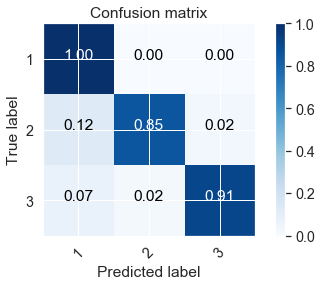

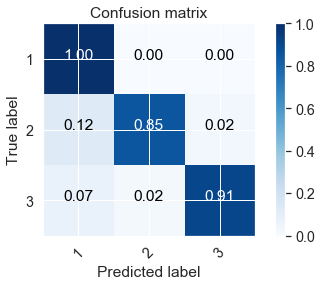

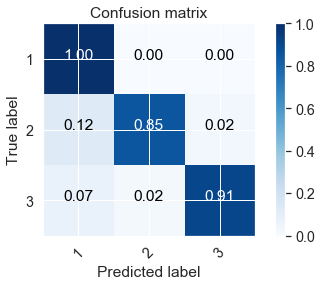

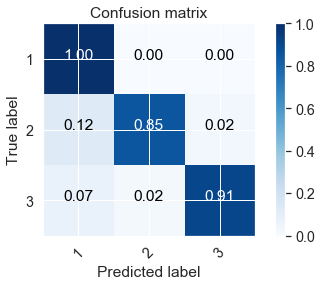

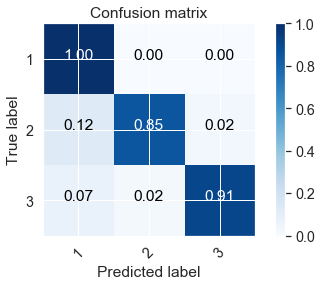

In [2698]:
cross_validation_result(k = 5)